In [1]:
using Pkg: activate
activate("../")

using LinearAlgebra
using WAV
using Plots


using Revise
using SpeechFeatures
using ExpFamilyDistributions
using MarkovModels
using ConvHMM

 Activating environment at `/mnt/matylda5/iondel/workspace/2020/ConvHMM/Project.toml`


In [2]:
using Base.Filesystem: isfile
if ! isfile("LDC93S1.wav")
    run(`wget https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.wav`)
end

if ! isfile("LDC93S1.phn")
    run(`wget https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.phn`)
end

sampling freq: 16000.0 Hz
duration: 2.92 s


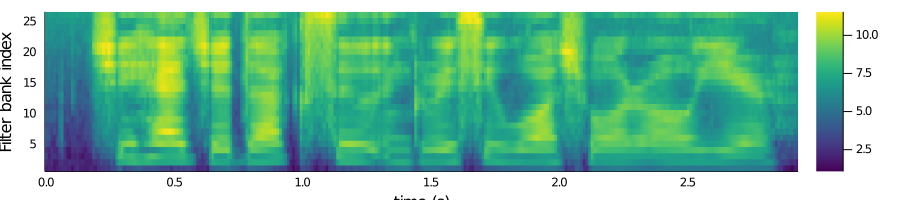

In [3]:
channels, srate = wavread("LDC93S1.wav", format="double")
channels *= typemax(Int16)
s = channels[:, 1]

println("sampling freq: $srate Hz\nduration: $(round(length(s) / srate, digits=2)) s")

logfbank = LogMelSpectrum(
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 1.0,
    nfilters = 26,
    lofreq = 80,
    hifreq = 8000
)

X = s |> logfbank
heatmap(
    Vector(range(0, length(s) / srate, length=size(X, 2))),
    1:size(X, 1),
    X,
    size = (900, 200),
    xlabel = "time (s)",
    ylabel = "Filter bank index",
    c = :viridis
)

In [4]:
phones = Set{String}()
trans = String[]
open("LDC93S1.phn") do f
    for line in eachline(f)
        phn = split(line)[3]
        push!(phones, phn)
        push!(trans, phn)
    end
end

emissionsmap = Dict(phn => i for (i, phn) in enumerate(phones))

Dict{String,Int64} with 26 entries:
  "ix"  => 1
  "kcl" => 2
  "sh"  => 3
  "r"   => 4
  "jh"  => 5
  "en"  => 6
  "ux"  => 7
  "gcl" => 8
  "eh"  => 9
  "epi" => 10
  "q"   => 11
  "h#"  => 12
  "s"   => 13
  "d"   => 14
  "dx"  => 15
  "ah"  => 16
  "g"   => 17
  "w"   => 18
  "hv"  => 19
  "ih"  => 20
  "k"   => 21
  "ao"  => 22
  "axr" => 23
  "y"   => 24
  "l"   => 25
  "dcl" => 26

In [5]:
function makehmm(nstates, pdfindex)
    fsm = FSM()
    prev = initstate(fsm)
    for i in 1:nstates
        s = addstate!(fsm, pdfindex = pdfindex)
        link!(fsm, prev, s)
        link!(fsm, s, s)
        prev = s
    end
    link!(fsm, prev, finalstate(fsm))
    fsm |> weightnormalize!
end

hmms = Dict(phone => makehmm(3, i) for (i, phone) in enumerate(phones));

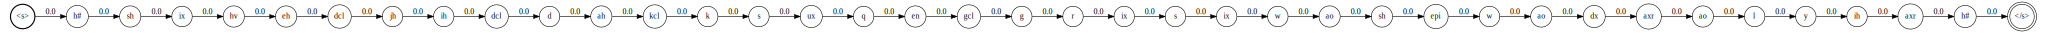

In [6]:
fsm = LinearFSM(trans) 

In [7]:
align = fsm ∘ hmms |> removenilstates!

In [22]:
S = length(phones)
D = size(X, 1)
K = 20
μ₀ = zeros(Float64, K+1)
Σ₀ = Matrix{Float64}(I, K+1, K+1)
a₀ = 1
b₀ = 1
models = [[ARNormal1D(K, μ₀, Σ₀, a₀, b₀) for i in 1:S] for d in 1:D];

In [15]:
for d in 1:D
    for (s, accstats) in zip(1:S, accstats_h(models[d], X[d, :], γ))
        m = models[d][s]
        η₀ = naturalparam(m.hprior)
        update!(m.hposterior, η₀ .+ accstats)
    end
end
Y

LoadError: UndefVarError: Y not defined

In [16]:
Z = [[1, 2, 3], [4, 5, 6]]
Z .+ Z

2-element Array{Array{Int64,1},1}:
 [2, 4, 6]
 [8, 10, 12]

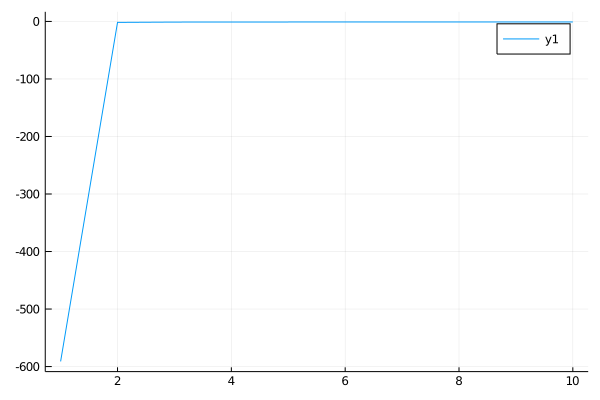

In [23]:
epochs = 10

elbos = []
for e in 1:epochs
    # E-step 
    lnαβ, totllh = αβrecursion(align, models(X), pruning = nopruning)
    γ = resps(align, lnαβ, dense = true)
    
    KL = 0.
    for d in 1:length(models)
        for m in models[d]
            KL += kldiv(m.hposterior, m.hprior)
            KL += kldiv(m.λposterior, m.λprior)
        end
    end
    push!(elbos, (totllh - KL) / length(X))
    
    # M-step (1) 
    #update_h!(models, X, γ)
    for d in 1:D
        for (s, accstats) in zip(1:S, accstats_h(models[d], X[d, :], γ))
            m = models[d][s]
            η₀ = naturalparam(m.hprior)
            update!(m.hposterior, η₀ .+ accstats)
        end
    end
    
    # M-step (2) 
    for d in 1:D
        for (s, accstats) in zip(1:S, accstats_λ(models[d], X[d, :], γ))
            m = models[d][s]
            η₀ = naturalparam(m.λprior)
            update!(m.λposterior, η₀ .+ accstats)
        end
    end
    
    #update_λ!(models, X, γ)
end

plot(elbos)

In [19]:
elbos

10-element Array{Any,1}:
 -1.0843681993297531
 -0.6903929120599804
 -0.5949010530899684
 -0.583286312630603
 -0.5821178679491145
 -0.5818852454219816
 -0.5818143918573805
 -0.5817876098715443
 -0.5817759420915337
 -0.5817703868968328

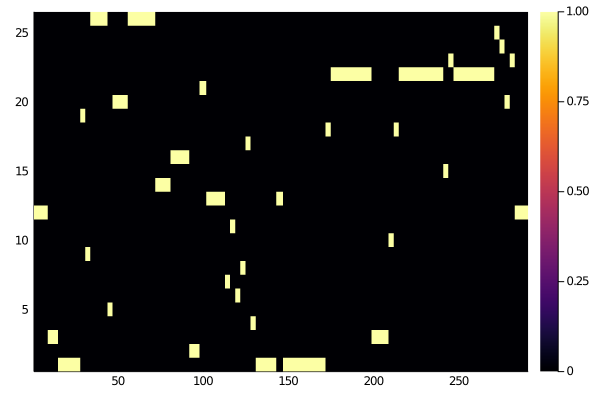

In [20]:
lnαβ, totllh = αβrecursion(align, models(X))
γ = resps(align, lnαβ, dense = true)
heatmap(γ)

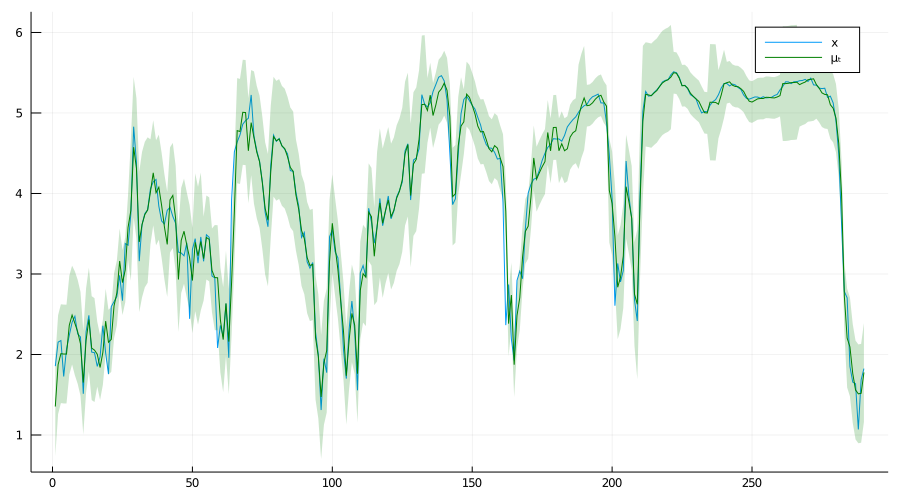

In [24]:
d = 1
t, prec = trajectory(models[d], X[d, :], γ)

plot(
    1:size(X, 2), 
    X[d, :],
    size = (900, 200),
    label = "x"
)
plot!(
    1:size(X, 2), 
    t,
    ribbon = sqrt.(1 ./ prec),
    fillalpha = 0.2,
    size = (900, 500),
    label = "μₜ",
    color = :green
)

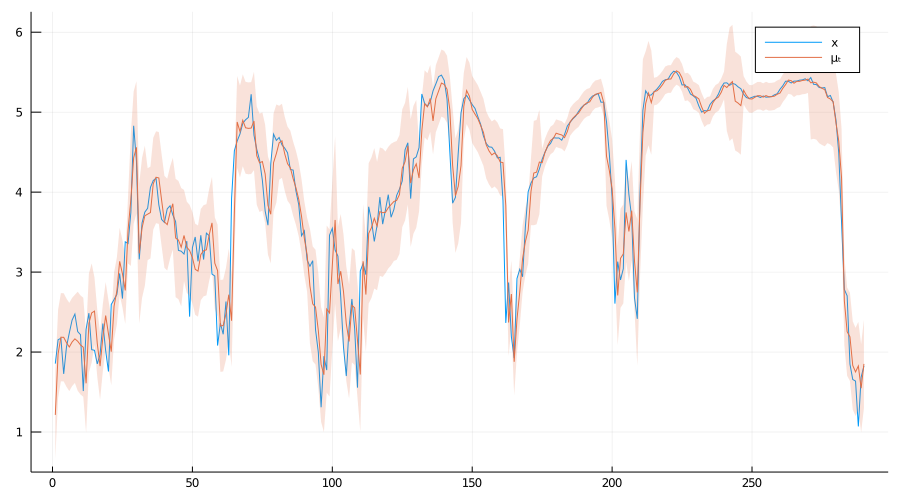

In [32]:
d = 1
t, prec = trajectory(models[d], X[d, :], γ)

plot(
    1:size(X, 2), 
    X[d, :],
    size = (900, 200),
    label = "x"
)
plot!(
    1:size(X, 2), 
    t,
    ribbon = sqrt.(1 ./ prec),
    fillalpha = 0.2,
    size = (900, 500),
    label = "μₜ"
)